# PID control of AIUTMAN robot

In [1]:
import mujoco_py
from mujoco_py import load_model_from_path, MjSim, MjViewer
import os
import numpy as np
import glfw
import matplotlib.pyplot as plt
import time

In [2]:
def euler_from_quaternion(w, x, y, z):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = np.arcsin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = np.arctan2(t3, t4)

    return roll_x, pitch_y, yaw_z 

Creating window glfw


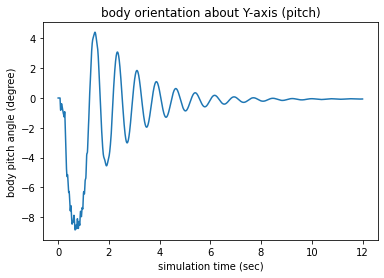

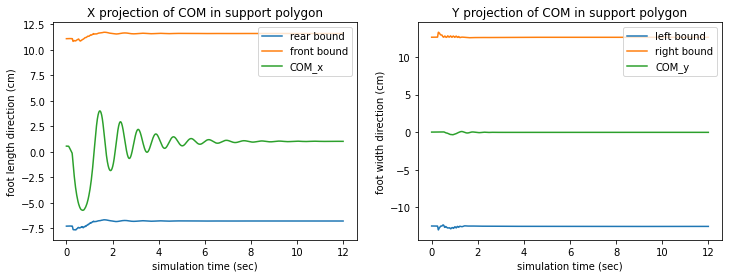

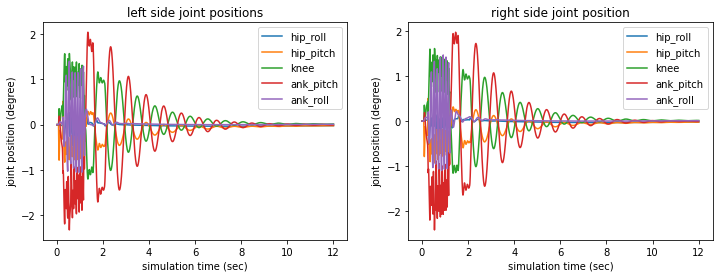

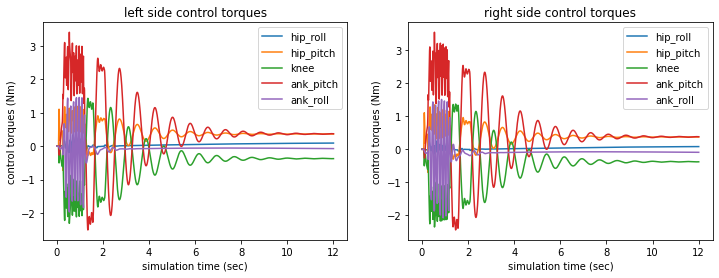

In [14]:
mj_path = mujoco_py.utils.discover_mujoco()
xml_path = os.path.join(mj_path, 'model', 'aiutman.xml')
model = load_model_from_path(xml_path)
sim = MjSim(model)
viewer = MjViewer(sim)

control_set = {#              [Kp,   Kv,    ki     qpos_d  qvel_d, ini_qpos, ini_qvel]
               "l_hip_yaw":   [20,   0.1,  1.0,   0,      0,      0,        0       ],  #0
               "l_hip_roll":  [40,   0.1,  30,    0,      0,      0,        0       ],  #1
               "l_hip_pitch": [80,   0.1,  30,    0,      0,      0,        0       ],  #2
               "l_knee":      [80,   0.1,  30,    0,      0,      0,        0       ],  #3
               "l_ank_pitch": [80,   0.1,  30,    0,      0,      0,        0       ],  #4
               "l_ank_roll":  [80,   0.1,  30,    0,      0,      0,        0       ],  #5
               "r_hip_yaw":   [20,   0.1,  1.0,   0,      0,      0,        0       ],  #6
               "r_hip_roll":  [40,   0.1,  30,    0,      0,      0,        0       ],  #7
               "r_hip_pitch": [80,   0.1,  30,    0,      0,      0,        0       ],  #8
               "r_knee":      [80,   0.1,  30,    0,      0,      0,        0       ],  #9
               "r_ank_pitch": [80,   0.1,  30,    0,      0,      0,        0       ],  #10
               "r_ank_roll":  [80,   0.1,  30,    0,      0,      0,        0       ],  #11
               "l_sho_pitch": [5,    0.1,  1.0,   0,      0,      0,        0       ],  #12
               "l_sho_roll":  [5,    0.1,  1.0,   0,      0,      0,        0       ],  #13
               "l_el":        [2,    0.1,  1.0,   0,      0,      0,        0       ],  #14
               "r_sho_pitch": [5,    0.1,  1.0,   0,      0,      0,        0       ],  #15
               "r_sho_roll":  [5,    0.1,  1.0,   0,      0,      0,        0       ],  #16
               "r_el":        [2,    0.1,  1.0,   0,      0,      0,        0       ],  #17
               "head_pan":    [2 ,   0.1,  1.0,   0,      0,      0,        0       ],  #18
               "head_tilt":   [2 ,   0.1,  1.0,   0,      0,      0,        0       ],  #19
               }
kp = 1*np.array(list(control_set.values()))[: , 0]
kv = 1*np.array(list(control_set.values()))[: , 1]
ki = 0.5*np.array(list(control_set.values()))[: , 2]
qpos_d = np.pi / 180 * np.array(list(control_set.values()))[: , 3]
qvel_d = np.pi / 180 * np.array(list(control_set.values()))[: , 4]
ini_qpos = np.pi / 180 * np.array(list(control_set.values()))[: , 5]
ini_qvel = np.pi / 180 * np.array(list(control_set.values()))[: , 6]

body_impulse = [0, 0] #1.5 #Ns
body_impuls_duration = 0.1 #s
shoot_impulse = 1.81 #Ns
shoot_impuls_duration = 0.1 #s
shoot_angle = 30 #degree

#initial conditions
sim_state = sim.get_state()
sim_state.qpos[7:27] = ini_qpos
sim_state.qvel[6:26] = ini_qvel
sim.set_state(sim_state)
sim.data.xfrc_applied[1][:2]  = [body_impulse[0]/body_impuls_duration,
                                 body_impulse[1]/body_impuls_duration]
shoot_force = shoot_impulse/shoot_impuls_duration
sim.data.xfrc_applied[24][:3] = [-shoot_force * np.cos(np.pi/180*shoot_angle),
                                  0,
                                  shoot_force * np.sin(np.pi/180*shoot_angle)]

Sup_X_min = [];  Sup_X_max = []; Sup_Y_min = []; Sup_Y_max = []
COM_X = [];      COM_Y = []
l_lower_body_pos = [];     r_lower_body_pos = []
l_lower_body_torque = [];  r_lower_body_torque = []
body_orientation = []; roll = []; pitch = []; yaw = [];

COM_xyz = sim.data.sensordata[:3]
old_joints_position = [0] * 20    # for taking integral and use in PID control
int_pos = np.zeros(20)

simulation_time = 12
for _ in range(int(simulation_time / model.opt.timestep)):
    sim_state = sim.get_state()

    sup_vert = sim.data.sensordata[6:18]
    sup_poly_x_max = max(sup_vert[0], sup_vert[3], sup_vert[6], sup_vert[9])
    sup_poly_x_min = min(sup_vert[0], sup_vert[3], sup_vert[6], sup_vert[9])
    sup_poly_y_max = max(sup_vert[1], sup_vert[4], sup_vert[7], sup_vert[10])
    sup_poly_y_min = min(sup_vert[1], sup_vert[4], sup_vert[7], sup_vert[10])
        
    joints_position = sim_state.qpos[7:27]
    joints_velocity = sim_state.qvel[6:26]
    body_quaternion0 = sim.data.qpos[3]
    body_quaternion1 = sim.data.qpos[4]
    body_quaternion2 = sim.data.qpos[5]
    body_quaternion3 = sim.data.qpos[6]
    roll_x, pitch_y, yaw_z = euler_from_quaternion(body_quaternion0, body_quaternion1,
                                                   body_quaternion2, body_quaternion3)
    
    Sup_X_min.append(sup_poly_x_min)
    Sup_X_max.append(sup_poly_x_max)
    Sup_Y_min.append(sup_poly_y_min)
    Sup_Y_max.append(sup_poly_y_max)
    COM_X.append(COM_xyz[0])
    COM_Y.append(COM_xyz[1])
    int_pos += model.opt.timestep * (( np.array(joints_position)
                                      +np.array(old_joints_position)) / 2-qpos_d)
    error = qpos_d - joints_position
    derror = qvel_d - joints_velocity
    apllied_torques = kp * error + kv * derror -ki *int_pos
    if sim.data.ncon > 0: sim.data.ctrl[:] = apllied_torques
    #sim.data.ctrl[:] = apllied_torques
    l_lower_body_pos.append(joints_position[1:6])
    r_lower_body_pos.append(joints_position[7:12])
    l_lower_body_torque.append(apllied_torques[1:6])
    r_lower_body_torque.append(apllied_torques[7:12])
    roll.append(roll_x)
    pitch.append(pitch_y)
    yaw.append(yaw_z)
    
    sim.step()
    viewer.render()
    #time.sleep(0.02)
    if sim.data.time > body_impuls_duration : sim.data.xfrc_applied[1][:2] = [0, 0]
    if sim.data.time > shoot_impuls_duration : sim.data.xfrc_applied[24][:3] = [0, 0, 0]
    old_joints_position = joints_position
    
    contact0 = sim.data.contact[0]
    geom_2 = sim.model.geom_id2name(contact0.geom2)
    if sim.data.ncon > 0 and geom_2 not in ('l_foot_link', 'r_foot_link','small_ball',
                                            'l_ank_roll_link', 'r_ank_roll_link'):
        break

glfw.destroy_window(viewer.window)

real_time = np.linspace(0, sim.data.time, num=len(COM_X))
plt.figure(figsize=(6,4))
plt.plot(real_time[1:] , [value * 180/np.pi for value in pitch[1:]])
plt.title("body orientation about Y-axis (pitch)")
plt.xlabel("simulation time (sec)")
plt.ylabel("body pitch angle (degree)")

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(real_time , [value * 100 for value in Sup_X_min])
plt.plot(real_time , [value * 100 for value in Sup_X_max])
plt.plot(real_time , [value * 100 for value in COM_X])
plt.title("X projection of COM in support polygon")
plt.xlabel("simulation time (sec)")
plt.ylabel("foot length direction (cm)")
plt.legend(["rear bound", "front bound", "COM_x"], loc = 'upper right')

plt.subplot(1, 2, 2)
plt.plot(real_time , [value * 100 for value in Sup_Y_min])
plt.plot(real_time , [value * 100 for value in Sup_Y_max])
plt.plot(real_time , [value * 100 for value in COM_Y])
plt.title("Y projection of COM in support polygon")
plt.xlabel("simulation time (sec)")
plt.ylabel("foot width direction (cm)")
plt.legend(["left bound", "right bound", "COM_y"], loc = 'upper right')

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(real_time , 180/np.pi * np.array(l_lower_body_pos))
plt.title("left side joint positions")
plt.xlabel("simulation time (sec)")
plt.ylabel("joint position (degree)")
plt.legend(["hip_roll", "hip_pitch", "knee", "ank_pitch", "ank_roll"], loc = 'upper right')

plt.subplot(1, 2, 2)
plt.plot(real_time , 180/np.pi * np.array(r_lower_body_pos))
plt.title("right side joint position")
plt.xlabel("simulation time (sec)")
plt.ylabel("joint position (degree)")
plt.legend(["hip_roll", "hip_pitch", "knee", "ank_pitch", "ank_roll"], loc = 'upper right')

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(real_time , np.array(l_lower_body_torque))
plt.title("left side control torques")
plt.xlabel("simulation time (sec)")
plt.ylabel("control torques (Nm)")
plt.legend(["hip_roll", "hip_pitch", "knee", "ank_pitch", "ank_roll"], loc = 'upper right')

plt.subplot(1, 2, 2)
plt.plot(real_time , np.array(r_lower_body_torque))
plt.title("right side control torques")
plt.xlabel("simulation time (sec)")
plt.ylabel("control torques (Nm)")
plt.legend(["hip_roll", "hip_pitch", "knee", "ank_pitch", "ank_roll"], loc = 'upper right')

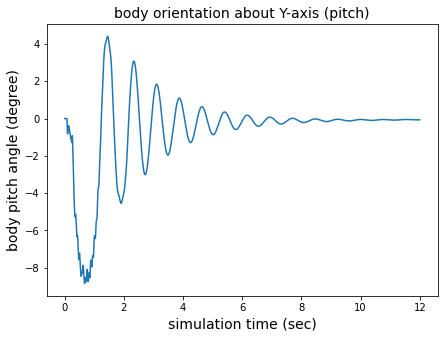

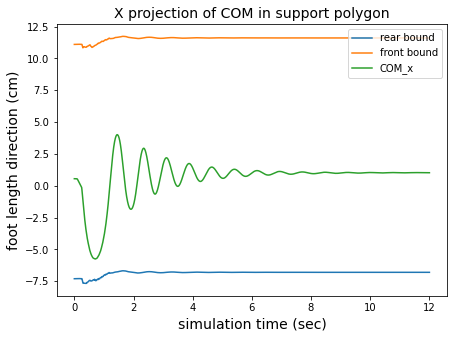

In [16]:
plt.figure(figsize=(7,5))
plt.plot(real_time[1:] , [value * 180/np.pi for value in pitch[1:]])
plt.title("body orientation about Y-axis (pitch)", size = 14)
plt.xlabel("simulation time (sec)", size = 14)
plt.ylabel("body pitch angle (degree)", size = 14)

plt.figure(figsize=(7,5))
plt.plot(real_time , [value * 100 for value in Sup_X_min])
plt.plot(real_time , [value * 100 for value in Sup_X_max])
plt.plot(real_time , [value * 100 for value in COM_X])
plt.title("X projection of COM in support polygon", size = 14)
plt.xlabel("simulation time (sec)", size = 14)
plt.ylabel("foot length direction (cm)", size = 14)
plt.legend(["rear bound", "front bound", "COM_x"], loc = 'upper right')
